In [347]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date
import datetime

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.signal import savgol_filter

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


In [348]:
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
average_over_year,
average_over_day,
apply_differencing,)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)

In [349]:
mpl.rcParams["figure.figsize"] = [8.0, 8.0]

# Project Outline


- [Introduction](#introduction)
- [Analyzing Energy dataset](#analyzing-energy-dataset)
- [Analyzing Weather Data](#analyzing-weather-dateset)
- [Feature engineering](#feature-engineering)
- [Baseline models](#baseline-models)
  - [SARIMAX](#sarimax)
  - [SVM](#svm)
- [Advanced models](#advanced-models)
  - [Simple NN](#simple-nn)
  - [RNN](#rnn)
  - [LSTM](#lstm)
- [Hyperparameter Tuning](#hyperparameter-tuning)
- [Conclusion and outlook](#conclusion-and-outlook)


# Introduction


"Climate change is one of the greatest challenges facing humanity, and we, as machine learning experts,
may wonder how we can help. Here we describe how machine learning can be a powerful tool in
reducing greenhouse gas emissions and helping society adapt to a changing climate. \
From smart grids to disaster management, we identify high impact problems where existing gaps can be filled by machine
learning, in collaboration with other fields. Our recommendations encompass exciting research questions
as well as promising business opportunities. We call on the machine learning community to join
the global effort against climate change." \
[David Rolnick et. al., 2019, Tackling Climate Change with Machine Learning](https://arxiv.org/abs/1906.05433)

"This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public here." \
[Nicholas Jhana, 2019, Hourly energy demand generation and weather](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

As described, in this project we are presented with two files, containing electrical consumption, generation, pricing and weather data for the region of Spain. \
In total there are up to 45 columns/features in the dataset and the data for each feature is hourly collected from 2015 to 2018, which results in 35064 timesteps.
With a dataset of this size and detail, it is only natural to thing about the application of Machine Learning and Neural Networks. 

On one hand it is interesting to forecast the electrical prices, especially for businesses. On the other hand the prediction of electrical consumption can play a crucial role in our fight against global warming. With accurate predictions on the electrical load and sufficient storage capacities, renewable energy sources, where energy production heavily depends on weather, can be planned ahead in time, stored and used later on, which reduces the necessity for other energy generation methods. In turn this might also have an influence on the price. \
Therefore it is interesting to investigate the dependencies between weather, energy generation, consumption and pricing. \
From intuition one might say that the weather and energy consumption are the most basic and indepent variables in this project, because the energy generation from renewable energy sources are dependent from the weather. The increase and decrease of energy prices depends on the supply and demand, or in our case the generation and consumption. 


![energy graph](./files/energy.jpg)

There are many ways to tackle a problem of this size and complexity. \
So first of all, we should define the goals of this project. This dataset is very suited for short term load forecasting, since the overall dataset has a length of 4 years and the resolution is down to hours. The model should be able to predict features for up to 24 hours into the future. \
For this project we are going to start with analyzing the dataset with statistical methods to get a feel for the dataset itself. \
And with a dataset that rich in features, it would be very beneficial apply Feature engineering methods like Correlation Analysis and Dimensionality Reduction to compress the dataset. \
With data like Weather and Energy demand it is worthwhile to look into seasonal trends and patterns and apply a Decomposition to the dataset. Furthermore, it would be practical to look into the history dependcy of the data and apply Autocorrelation and Partial Autocorrelation functions to analyze the dataset. \
For the Basemodel I choose to approach the task as a Regression Problem and model it with the SARIMAX-Model and the SVR-Model. \
The advanced model will be a neural network. And for this NN we will investigate different architectures to find the most suitable Model for this task. We especially will look into recurrent neural networks for their capability to process past data to predict the future. Furthermore, we will model it in a way, that a direct multistep prediction is possible.\

![model graph](./files/DDE_graphs_1.png)

In [350]:
SKIP_SARIMAX = True
SKIP_SVM = True
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = True

# Analyzing energy dataset


In [351]:
df_energy = pd.read_csv("energy_dataset.csv")
df_energy = set_timestamp_index(df_energy, "time")
df_energy

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


## General Analysis


In [352]:
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


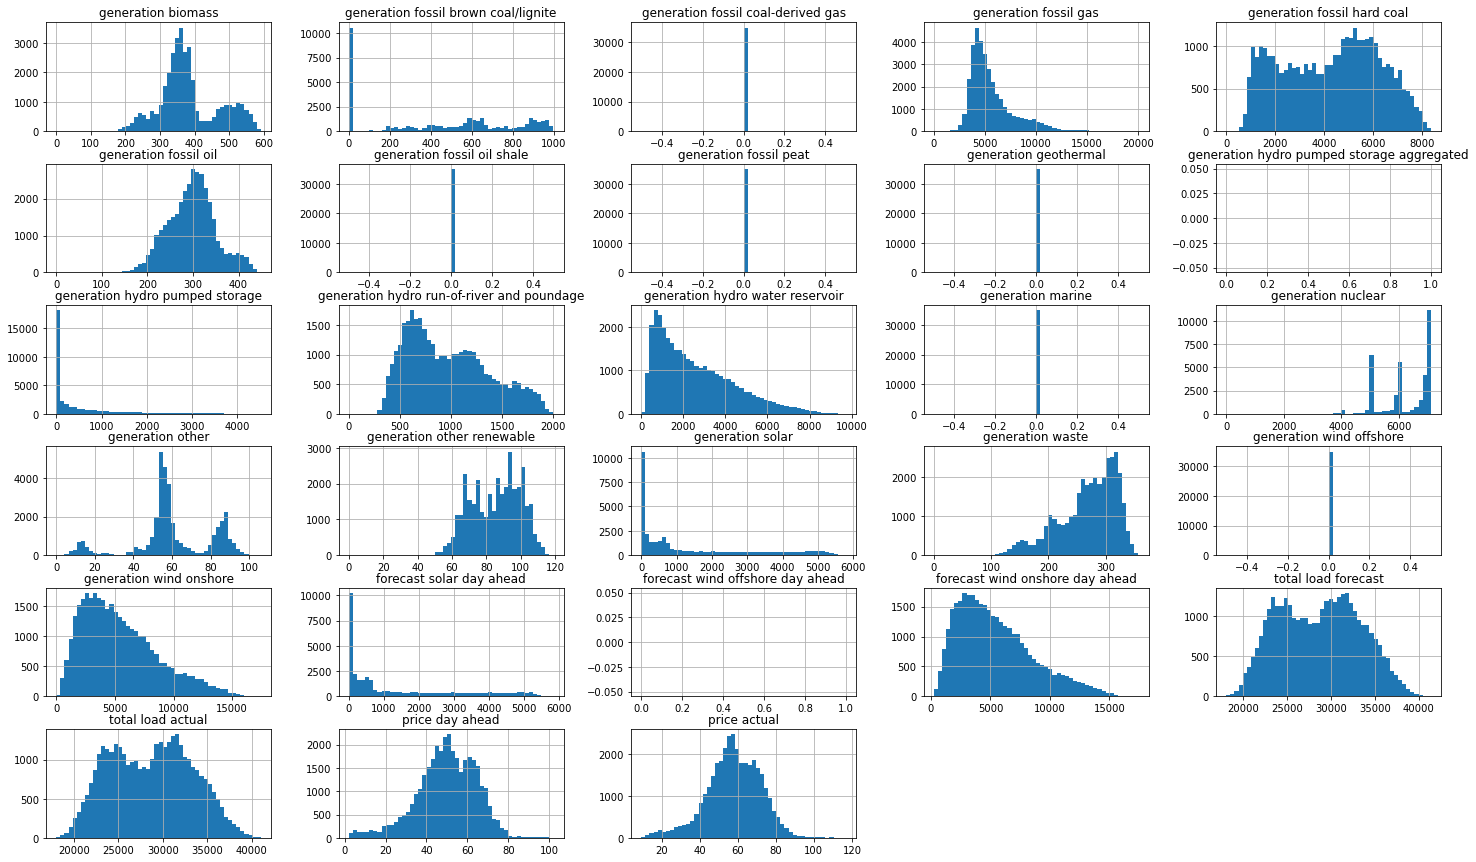

In [353]:
df_energy.hist(bins=50, figsize=(25, 15))
plt.show()

## Data Preparation and Cleaning


### Dataframe cleaning


As you can see a few columns have no data in them:
  - generation fossil coal-derived gas
  - generation fossil oil shale
  - generation fossil peat
  - generation geothermal
  - generation hydro pumped storage aggregated
  - generation marine
  - generation wind offshore
  - forecast wind offshore eday ahead

There are also columns which dont interest us like:
  - forecast solar day ahead
  - forecast wind onshore day ahead 
  - total load forecast
  - price day ahead 

Furthermore, you can observe that the Count of values is different from the length of the DataFrame. Therefore NaN-Values are in the Dataframe and need to be handled. \
I choose to linear interpolate the data.

In [354]:
# seperating forecasts
df_forecasts = df_energy[["forecast solar day ahead",
                        "forecast wind onshore day ahead",
                        "total load forecast",
                        "price day ahead",
                        "total load actual",
                        "price actual",
                        'generation solar',
                        "generation wind offshore",
                        "generation wind onshore"]]

# remove data with no values
df_energy = remove_columns(
    df_energy,
    [
        "generation fossil coal-derived gas",
        "generation fossil oil shale",
        "generation fossil peat",
        "generation geothermal",
        "generation hydro pumped storage aggregated",
        "generation marine",
        "generation wind offshore",
        "forecast wind offshore day ahead",
    ],
)


# remove useless data
df_energy = remove_columns(
    df_energy,
    [
        "forecast solar day ahead",
        "forecast wind onshore day ahead",
        "total load forecast",
        "price day ahead",
    ],
)

# interpolate for missing data
df_energy.interpolate(inplace=True)
generation_parameters = [x for x in df_energy.columns if "generation" in x]
energy_parameters = [x for x in df_energy.columns if x not in generation_parameters]
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.531343,448.094570,5622.700647,4256.531271,298.342417,475.582706,972.201902,2605.534123,6263.483430,60.226030,85.634326,1432.818546,269.418692,5464.980450,28698.281385,57.884023
std,85.346266,354.618269,2201.510984,1961.988937,52.519927,792.312704,400.712304,1835.175078,840.272333,20.238792,14.076948,1679.961733,50.218423,3213.586296,4575.828854,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18041.000000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,24807.000000,49.347500
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.500000,28902.000000,58.020000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7399.500000,32194.250000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,41015.000000,116.800000


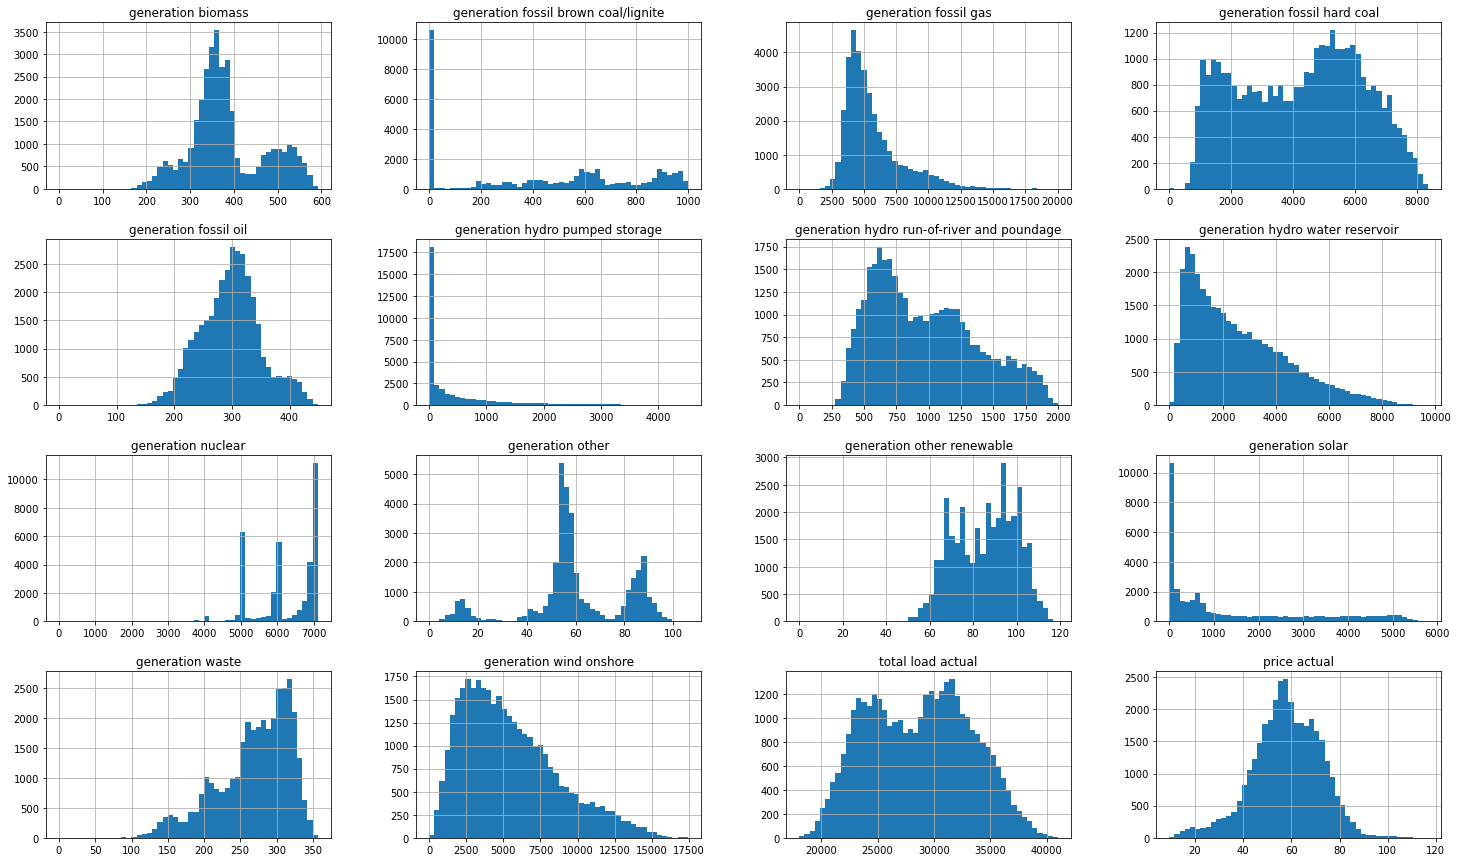

In [355]:
df_energy.hist(bins=50, figsize=(25, 15))
plt.show()

### Checking for overall length of the dataframe


Now we need to make sure that the dataset has the right amount of timesteps and to check this we can calculate how many timesteps there are between two dates with pd.date_range().\
It even considers leap years and daylight savings.\
Luckily the dataset is complete and no changes need to be made. 

In [356]:
date_period = pd.date_range(
    start="2015-01-01 00:00:00+1", end="2018-12-31 23:00:00+1", freq="H"
)
print("Length of the data frames: ", len(df_energy))
print("Length of the time periode: ", len(date_period))

Length of the data frames:  35064
Length of the time periode:  35064


## Checking energy mix

In the histogram we could see that the generation of solar energy is fairly small in compairision to other energy generation methods.\
Thats why we are looking into the energy mix. For this we group the data by their month and average them over the years.\
As you can see the amount of energy generated by solar energy is quite small in comparison to the other energy generation methods.\
Even in the hot summer months of spain, solar energy only contributes to ~6.7% of spains energy generation.\
Thats why I am assuming that temperature and solar energy generation won't have much of an effect on our predictions.

In [357]:
# grouping the data by the month and averaging over the years.
df_generation = average_over_year(df_energy)
df_generation = remove_columns(df_generation,["total load actual","price actual"])

In [358]:
months_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_generation['month'] = months_list
df_generation.set_index('month',inplace=True)

In [359]:
fig= px.bar(df_generation)
fig.update_layout(barmode="relative")
fig.show()

In [360]:
# normalizing the data for easier percentage evaluation
df_generation['sum'] = df_generation.sum(axis=1)
for col in df_generation.columns:
    df_generation[col]= df_generation[col]/df_generation['sum']
df_generation = remove_columns(df_generation,["sum"])

In [361]:
fig= px.bar(df_generation)
fig.show()

# Analyzing weather dataset


In [362]:
df_weather = pd.read_csv("weather_features.csv")
df_weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## General Analysis


In [363]:
df_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


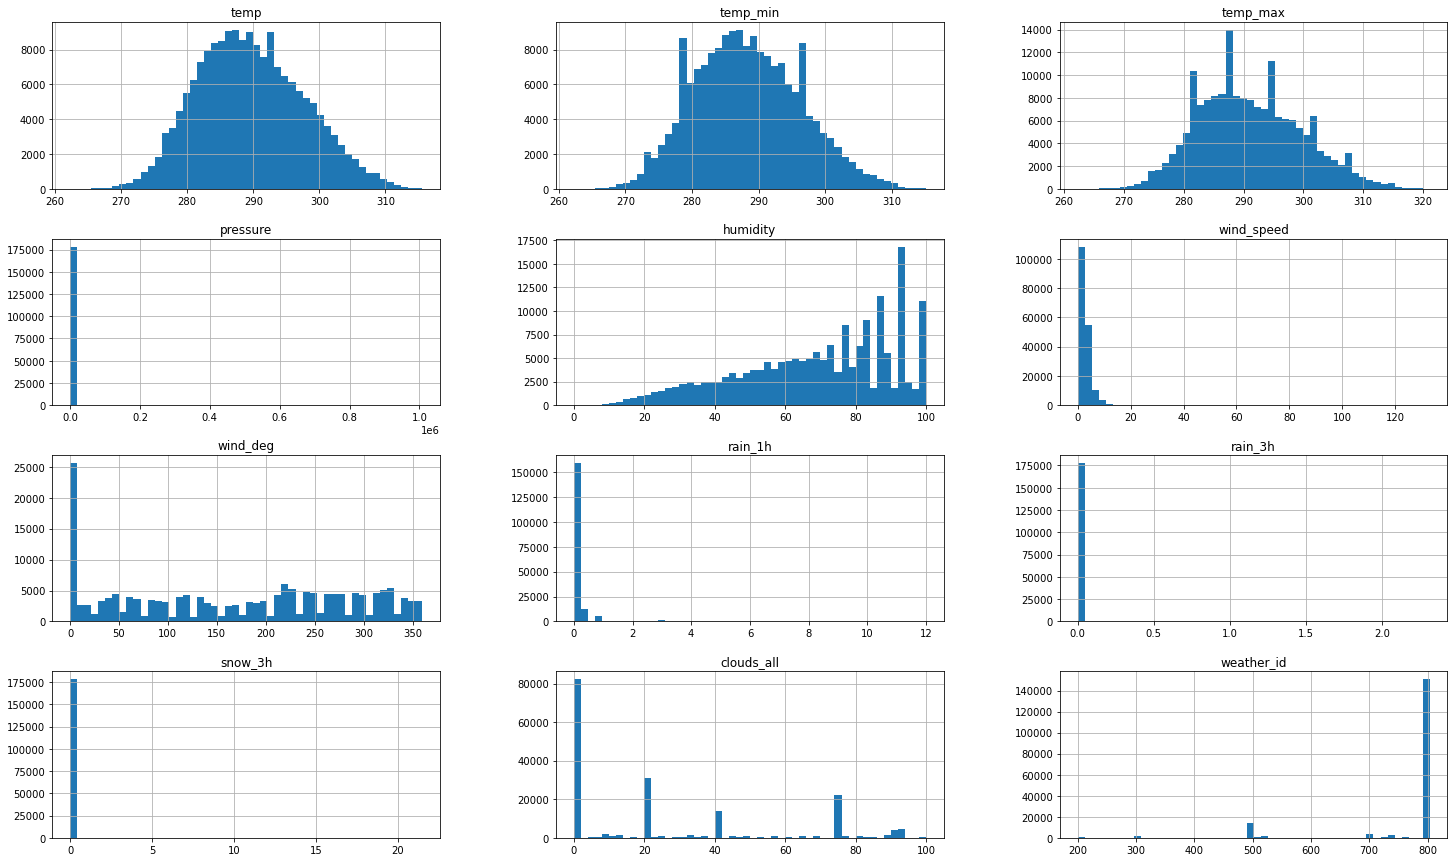

In [364]:
df_weather.hist(bins=50, figsize=(25, 15))
plt.show()

## Data Preparation and Analysis


### Outlier Handling


From the scaling of the histogram above you can tell that there are outliers in the following columns:
  - pressure
  - windspeed
  
I choose to remove the outliers by masking them and remove any value that is under or over a certain treshhold. The missing data is linear interpolated.

Furthermore, following columns dont have useful information for us:
  - temp_min
  - temp_max
  - rain_1h
  - rain_3h
  - snow_3h
  - clouds_all
  - weather_id
  - weather_main
  - weather_description
  - weather_icon


In [365]:
# Removing outliers with upper and lower treshhold
df_weather["pressure"].mask(df_weather["pressure"] >= 1.1e3, inplace=True)
df_weather["pressure"].mask(df_weather["pressure"] <= 0.9e3, inplace=True)
df_weather["wind_speed"].mask(df_weather["wind_speed"] >= 15, inplace=True)

# interpolating missing data
df_weather.interpolate(inplace=True)

# dropping columns with no useful data
df_weather = remove_columns(
    df_weather,
    [
        "temp_min",
        "temp_max",
        "rain_1h",
        "rain_3h",
        "snow_3h",
        "clouds_all",
        "weather_id",
        "weather_main",
        "weather_description",
        "weather_icon",
    ],
)

weather_parameters = [x for x in df_weather.columns]

In [366]:
df_weather.describe()

,temp,pressure,humidity,wind_speed,wind_deg
count,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,1016.206927,68.423457,2.462953,166.591190
std,8.026199,12.448205,21.902888,2.024503,116.611927
min,262.240000,918.000000,0.000000,0.000000,0.000000
25%,283.670000,1013.000000,53.000000,1.000000,55.000000
50%,289.150000,1018.000000,72.000000,2.000000,177.000000
75%,295.150000,1022.000000,87.000000,4.000000,270.000000
max,315.600000,1090.000000,100.000000,14.000000,360.000000


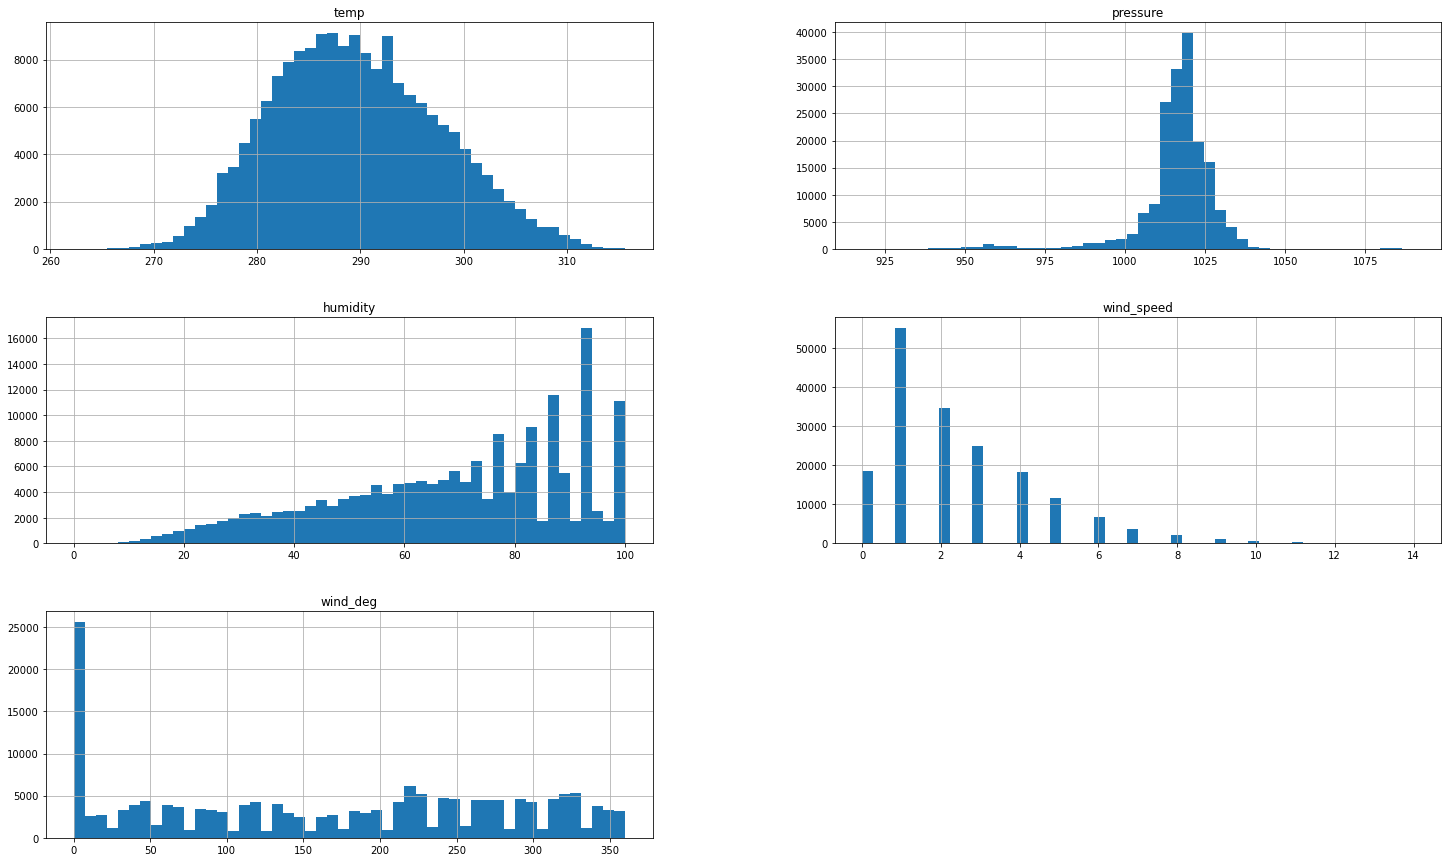

In [367]:
df_weather.hist(bins=50, figsize=(25, 15))
plt.show()

### Splitting into city data

In [368]:
# convert temp from Kelvin to Celsius
df_weather["temp"] = df_weather["temp"].apply(lambda x: x - 273.15)

# splitting data by their city
city_list = ["Valencia", "Madrid", "Bilbao", "Barcelona", "Seville"]
df_cities = [df_weather.query(f"city_name == '{x}'") for x in df_weather.city_name.unique()]

for i, df in enumerate(df_cities):
    df_cities[i] = set_timestamp_index(df.copy(deep=True), "dt_iso")

### Checking overall length of the dataframes

Now we need to inspect the lenght of the dataframes again.\
As you can see the dataframes have different lengths and they all differ from the 35064 timesteps they should have.\
So now we need to investigate why they all have different lenghts.\
As you can see in the dataframe below, the difference mostly occours due to a slight weather change within the hour timestamp.

In [369]:
for name, df in zip(city_list, df_cities):
    print(f"Length of the {name} DataFrame: ", len(df))

Length of the Valencia DataFrame:  35145
Length of the Madrid DataFrame:  36267
Length of the Bilbao DataFrame:  35951
Length of the Barcelona DataFrame:  35476
Length of the Seville DataFrame:  35557


In [370]:
# extracting duplicate timestamps
df_city_duplicates = display_double_timestamps()
df_valencia_duplicates = df_city_duplicates[0]
df_valencia_duplicates

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-06-15 21:00:00+02:00,Valencia,289.610,288.650,290.930,1018,100,3,330,0.9,0.0,0.0,75,501,rain,moderate rain,10d
2015-06-15 21:00:00+02:00,Valencia,289.610,288.650,290.930,1018,100,3,330,0.9,0.0,0.0,75,200,thunderstorm,thunderstorm with light rain,11d
2015-06-15 22:00:00+02:00,Valencia,289.240,288.150,290.370,1018,100,2,300,0.9,0.0,0.0,75,501,rain,moderate rain,10n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-16 21:00:00+01:00,Valencia,290.150,290.150,290.150,1019,93,3,40,0.3,0.0,0.0,75,520,rain,light intensity shower rain,09n
2018-12-13 08:00:00+01:00,Valencia,285.140,284.150,286.150,1011,76,4,270,0.3,0.0,0.0,40,500,rain,light rain,10n
2018-12-13 08:00:00+01:00,Valencia,285.140,284.150,286.150,1011,76,4,270,0.3,0.0,0.0,40,701,mist,mist,50n
2018-12-13 09:00:00+01:00,Valencia,283.640,283.150,284.150,1010,93,2,270,0.3,0.0,0.0,40,500,rain,light rain,10d


In [371]:
# cleaning the dataframe and removing duplicated timestamps
for i, item in enumerate(df_cities):
    df_cities[i] = remove_duplicates(item)

for name, df in zip(city_list, df_cities):
    print(f"Length of the {name} DataFrame: ", len(df))

df_valencia = df_cities[0]
df_madrid = df_cities[1]
df_bilbao = df_cities[2]
df_barcelona = df_cities[3]
df_seville = df_cities[4]

Length of the Valencia DataFrame:  35064
Length of the Madrid DataFrame:  35064
Length of the Bilbao DataFrame:  35064
Length of the Barcelona DataFrame:  35064
Length of the Seville DataFrame:  35064


# Analyzing the Baseline

# Feature Engineering

In [372]:
combined_df = pd.concat([df_valencia, df_energy], axis=1)
combined_df = remove_columns(combined_df, ["city_name"])

## Checking for stationarity of the dataset

Lets have a look at the dataset. \
As you can see, the data is changing alot and for Machine Learning Algorithms its really hard to predict those changes.\
Machine Learning algorithms mostly expect stationary data. \
Stationarity is a term in statistics where the mean and the variance dont change over time and there's no seasonality.\
Two common techniques are the log-transform and differencing, which we will both apply to the dataset.

Text(0.5, 0.98, 'Original data set')

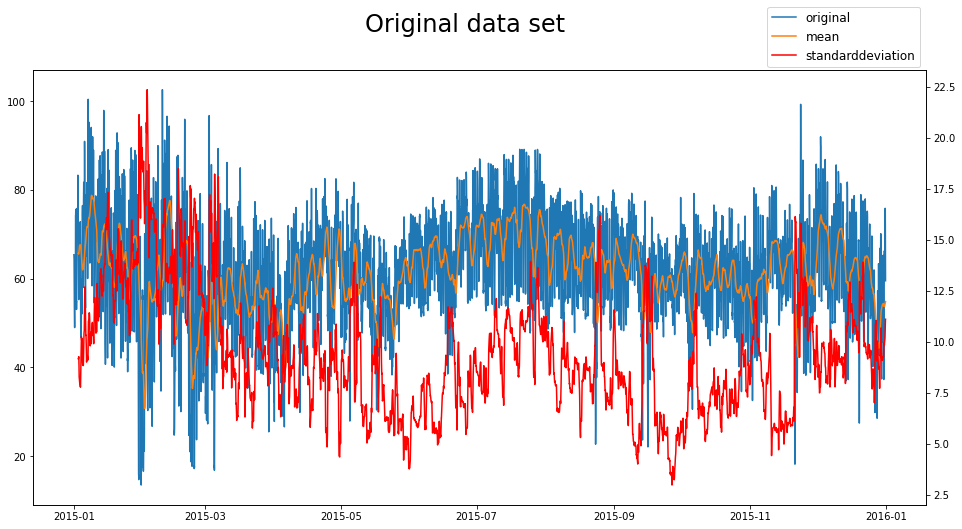

In [410]:
start = '2015-01-01'
end = '2015-12-31'
feature = 'price actual'
window = 48
mean = combined_df[start:end][feature].rolling(window).mean()
std = combined_df[start:end][feature].rolling(window).std()
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(combined_df[start:end][feature],label = 'original')
ax.plot(mean,label = 'mean')
ax2 = ax.twinx()
ax2.plot(std,label = 'standarddeviation',color='r')
fig.legend(bbox_to_anchor=(0.9,1),fontsize = 12)
fig.suptitle('Original data set',fontsize = 24)

### Differencing

In [411]:
diff_df = combined_df.copy(deep=True)
diff_df = diff_df.diff().dropna()

Text(0.5, 0.98, 'First order differencing')

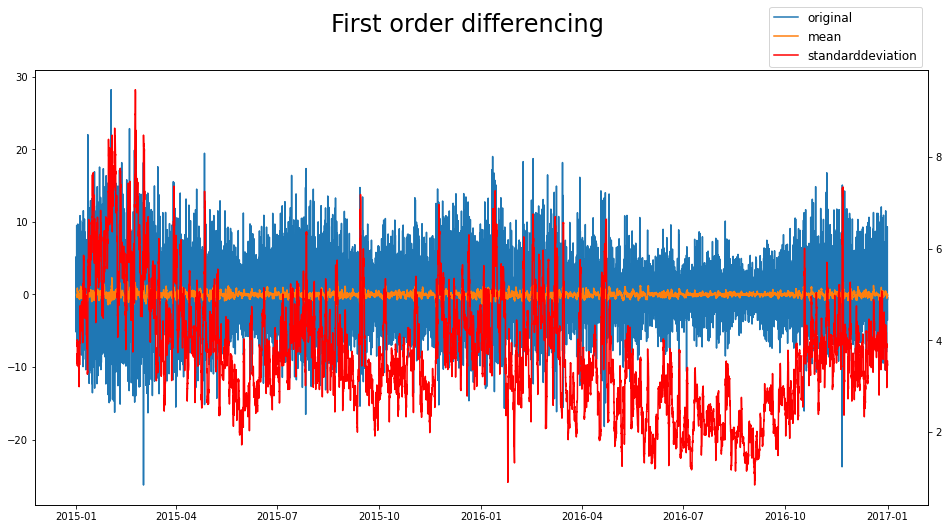

In [414]:
start = '2015-01-01'
end = '2016-12-31'
feature = 'price actual'
window=24
mean = diff_df[start:end][feature].rolling(window).mean()
std = diff_df[start:end][feature].rolling(window).std()
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(diff_df[start:end][feature],label = 'original')
ax.plot(mean,label = 'mean')
ax2 = ax.twinx()
ax2.plot(std,label = 'standarddeviation',color='r')
fig.legend(bbox_to_anchor=(0.9,1),fontsize=12)
fig.suptitle('First order differencing',fontsize=24)

### Log Transform

Text(0.5, 0.98, 'Log Transform')

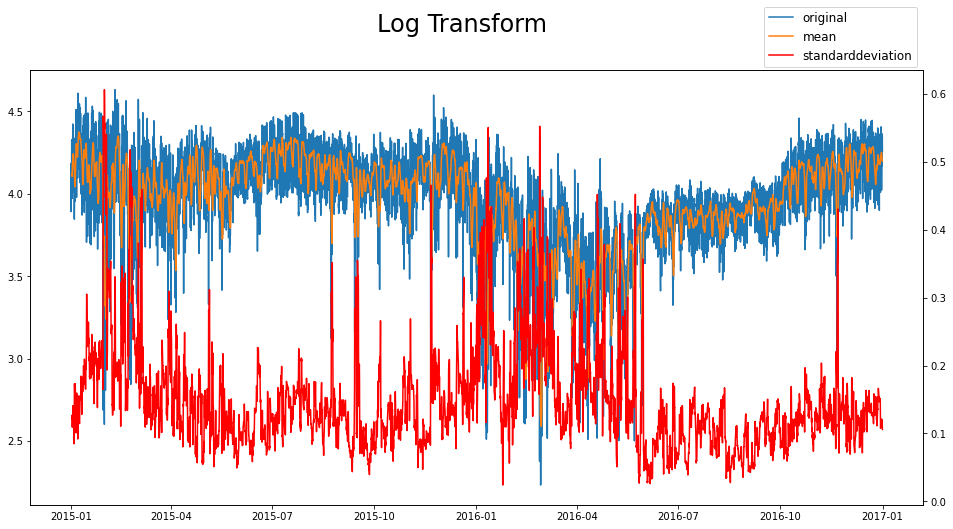

In [413]:
start = '2015-01-01'
end = '2016-12-31'
feature = 'price actual'
window=24
mean = np.log(combined_df[start:end][feature]).rolling(window).mean()
std = np.log(combined_df[start:end][feature]).rolling(window).std()
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.log(combined_df[start:end][feature]),label = 'original')
ax.plot(mean,label = 'mean')
ax2 = ax.twinx()
ax2.plot(std,label = 'standarddeviation',color='r')
fig.legend(bbox_to_anchor=(0.9,1),fontsize = 12)
fig.suptitle('Log Transform',fontsize = 24)

### 2nd order differencing

In [377]:
diff_df2 = diff_df.copy(deep=True)
diff_df2 = diff_df.diff().dropna()

Text(0.5, 0.98, 'Second order differencing ')

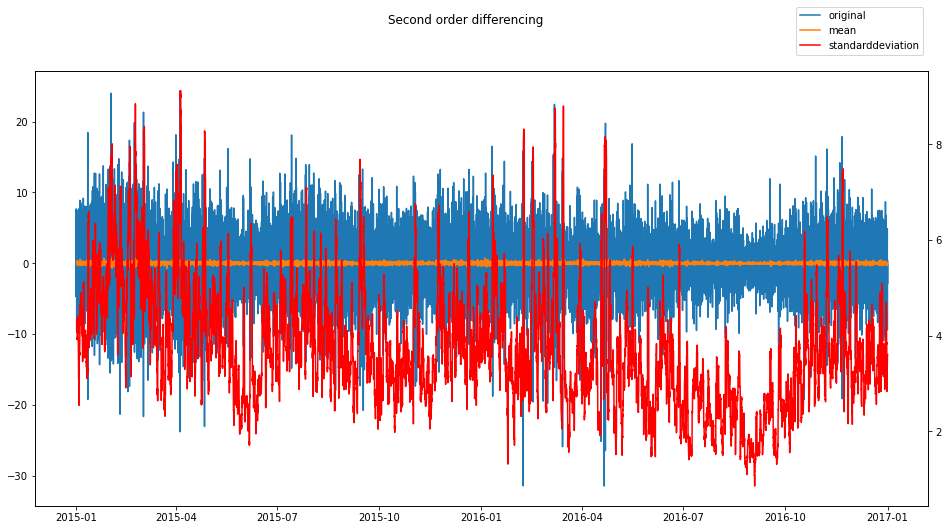

In [378]:
start = '2015-01-01'
end = '2016-12-31'
feature = 'price actual'
window=24
mean = diff_df2[start:end][feature].rolling(window).mean()
std = diff_df2[start:end][feature].rolling(window).std()
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(diff_df2[start:end][feature],label = 'original')
ax.plot(mean,label = 'mean')
ax2 = ax.twinx()
ax2.plot(std,label = 'standarddeviation',color='r')
fig.legend(bbox_to_anchor=(0.9,1),fontsize = 12)
fig.suptitle('Second order differencing',fontsize = 24)

### Log Transform + Differencing

Text(0.5, 0.98, 'Log-transform and differencing')

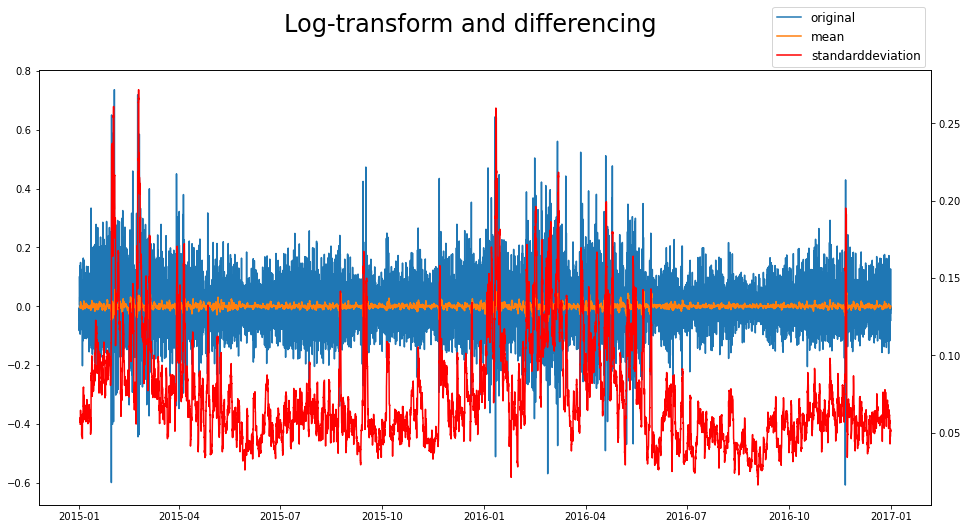

In [408]:
start = '2015-01-01'
end = '2016-12-31'
feature = 'price actual'
window=24
mean = np.log(combined_df[start:end][feature]).diff().dropna().rolling(window).mean()
std = np.log(combined_df[start:end][feature]).diff().dropna().rolling(window).std()
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.log(combined_df[start:end][feature]).diff().dropna(),label = 'original')
ax.plot(mean,label = 'mean')
ax2 = ax.twinx()
ax2.plot(std,label = 'standarddeviation',color='r')
fig.legend(bbox_to_anchor=(0.9,1),fontsize=12)
fig.suptitle('Log-transform and differencing',fontsize = 24)

### Conclusion

With the differencing-transform the mean value looks fine, but the variance still looks quite unstable\
The 2nd order differecing doesnt help alot with the standarddeviation. \
The log-transform is not sufficient. The mean and the standarddeviation still fluctuate alot.\
And the combination of the log- and differencing-transform still doesnt improve the standarddeviation.\
So for this work we will stick with the simple differencing transform.

### Reconstruction of differencing 

So we will feed the model the differenced dataset and let it predict the difference in the future. So basically it is predicting the change instead of the actual value.\
But we can reconstruct the actual values from the differencing.\
If you are given the prediction on the difference (t=0..23), you need to get the value before the prediction started (t=-1) and calculate the cumulative sum of the predictions.\
Heres an example:

In [380]:
start = '2015-01-01 01:00:00+1'
end = '2015-01-01 23:00:00+1'
feature = 'price actual'
date_range = pd.date_range(start,end,freq='H')
test_set = diff_df[start:end][feature]

init_idx = date_range[0] - timedelta(hours=1)
init_value = combined_df.loc[init_idx,feature]

reconstruction = pd.Series(init_value)
reconstruction = reconstruction.append(test_set)
reconstruction = reconstruction.cumsum()[1:]

result = pd.concat([reconstruction,combined_df[start:end][feature]],axis=1)
result

,0,price actual
2015-01-01 01:00:00+01:00,64.92,64.92
2015-01-01 02:00:00+01:00,64.48,64.48
2015-01-01 03:00:00+01:00,59.32,59.32
2015-01-01 04:00:00+01:00,56.04,56.04
2015-01-01 05:00:00+01:00,53.63,53.63
2015-01-01 06:00:00+01:00,51.73,51.73
2015-01-01 07:00:00+01:00,51.43,51.43
2015-01-01 08:00:00+01:00,48.98,48.98
2015-01-01 09:00:00+01:00,54.20,54.20
2015-01-01 10:00:00+01:00,58.94,58.94


In [381]:
# # implementation of dickey fuller test
# from statsmodels.tsa.stattools import adfuller

# def test_stationarity(data):
#     result=adfuller(data)
#     print('ADF : ' + str(result[0]))
#     print('pvalue : ' + str(result[1]))
#     print('Number of lags used : ' + str(result[2]))
#     print('Number of obs used : ' + str(result[3]))
#     print('Critical value at 1% :' + str(result[4]['1%']))
#     print('Critical value at 5% :' + str(result[4]['5%']))
#     print('Critical value at 10% :' + str(result[4]['10%']))
#     print('- - - Result: - - -')
#     print('Data is stationary!' if result[0] <  result[4]['1%'] else 'Data is not stationary!')

# start = '2015-01-01'
# end = '2018-12-31'

# test_stationarity(combined_df[start:end][feature])
# test_stationarity(diff_df[start:end][feature])
# test_stationarity(diff_df2[start:end][feature])
# test_stationarity(np.log(combined_df[start:end][feature]).diff().dropna())

ADF : -9.147016232851227
pvalue : 2.7504934849336446e-15
Number of lags used : 50
Number of obs used : 35013
Critical value at 1% :-3.4305367814665044
Critical value at 5% :-2.8616225527935106
Critical value at 10% :-2.566813940257257
- - - Result: - - -
Data is stationary!
ADF : -32.28628556025747
pvalue : 0.0
Number of lags used : 52
Number of obs used : 35010
Critical value at 1% :-3.430536797472945
Critical value at 5% :-2.8616225598677394
Critical value at 10% :-2.5668139440226856
- - - Result: - - -
Data is stationary!
ADF : -50.798426715237696
pvalue : 0.0
Number of lags used : 52
Number of obs used : 35009
Critical value at 1% :-3.4305368028090353
Critical value at 5% :-2.861622562226085
Critical value at 10% :-2.5668139452779717
- - - Result: - - -
Data is stationary!
ADF : -31.960371415253352
pvalue : 0.0
Number of lags used : 52
Number of obs used : 35010
Critical value at 1% :-3.430536797472945
Critical value at 5% :-2.8616225598677394
Critical value at 10% :-2.566813944022

## Resampling

In [441]:
resample_df = combined_df.copy(deep=True)
resample_df.asfreq('1H')
resample_df = resample_df.resample('30min').asfreq().interpolate('cubic')
resample_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.675000,1001.000000,77.000000,1.000000,62.000000,447.000000,3.290000e+02,4844.000000,4821.000000,162.000000,...,6378.000000,25385.000000,65.410000,28251.000000,2866.000000,2.866000e+03,1.0,1.0,0.000000e+00,0.0
2015-01-01 00:30:00+01:00,-2.429750,1000.713394,76.631187,1.323198,76.612551,447.641915,3.232474e+02,5131.446012,4778.278885,160.002782,...,6144.407097,25027.997594,64.636599,28074.687959,3046.690364,4.432504e+03,1.0,1.0,-2.331020e-27,0.5
2015-01-01 01:00:00+01:00,-2.675000,1001.000000,77.000000,1.000000,62.000000,449.000000,3.280000e+02,5196.000000,4755.000000,158.000000,...,5890.000000,24382.000000,64.920000,27818.000000,3436.000000,6.302000e+03,1.0,1.0,0.000000e+00,1.0
2015-01-01 01:30:00+01:00,-3.117500,1001.536606,77.618813,0.426802,37.637449,449.608085,3.317526e+02,5087.803988,4704.721115,156.747218,...,5650.342903,23574.752406,65.215901,27414.062041,3839.309636,8.327996e+03,1.0,1.0,2.331020e-27,1.5
2015-01-01 02:00:00+01:00,-3.464000,1002.000000,78.000000,0.000000,23.000000,448.000000,3.230000e+02,4857.000000,4581.000000,157.000000,...,5461.000000,22734.000000,64.480000,26796.000000,4062.000000,1.036400e+04,1.0,1.0,0.000000e+00,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 21:00:00+01:00,8.510000,1029.000000,81.000000,3.000000,300.000000,292.000000,0.000000e+00,7025.000000,2422.000000,168.000000,...,3503.000000,28071.000000,74.300000,23987.000000,-4084.000000,-2.070918e+06,12.0,31.0,0.000000e+00,21.0
2018-12-31 21:30:00+01:00,7.752624,1028.965824,82.371029,2.834563,308.841646,292.153586,-1.256524e-38,6787.035248,2354.352204,165.141080,...,3559.066740,26944.112904,72.120047,23331.351267,-3612.761637,-2.072589e+06,12.0,31.0,1.242473e-13,21.5
2018-12-31 22:00:00+01:00,6.990000,1029.000000,81.000000,2.000000,310.000000,293.000000,0.000000e+00,6562.000000,2293.000000,163.000000,...,3586.000000,25801.000000,69.890000,22748.000000,-3053.000000,-2.073972e+06,12.0,31.0,0.000000e+00,22.0
2018-12-31 22:30:00+01:00,6.357376,1029.034176,78.128971,1.415437,306.158354,292.846414,1.256524e-38,6543.714752,2232.147796,162.108920,...,3608.433260,24888.887096,68.759953,22438.648733,-2450.238363,-2.075053e+06,12.0,31.0,-1.242473e-13,22.5


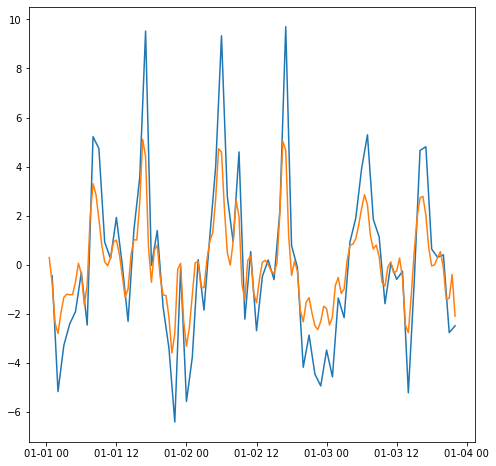

In [442]:
start = '2015-01-01 01:00:00+1'
end = '2015-01-03 23:00:00+1'
feature = 'price actual'
plt.plot(combined_df[start:end][feature].diff())
plt.plot(resample_df[start:end][feature].diff())

## Savitzky Golay Filter

Due to the dynamic nature of the data and resolution of the time, it can happen that from one hour to another values increase drastically. This is true especially for prices. At the end of the hour the price is recorded and it creates big differences within one timestep, which is hard to predict for the Machine Learning algorithms.\
To eleviate this problem we will use the Savitzky Golay Filter. \
A Savitzky–Golay filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the precision of the data without distorting the signal tendency. This is achieved, in a process known as convolution, by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares.

In [382]:
start = '2015-01-01'
end = '2015-01-2'
feature = 'price actual'
window = 7
order = 4 
y = combined_df[start:end][feature]
yhat = pd.DataFrame(savgol_filter(y,window,order),index= y.index)

Text(0.5, 0.98, 'Savitzky Golay Filter')

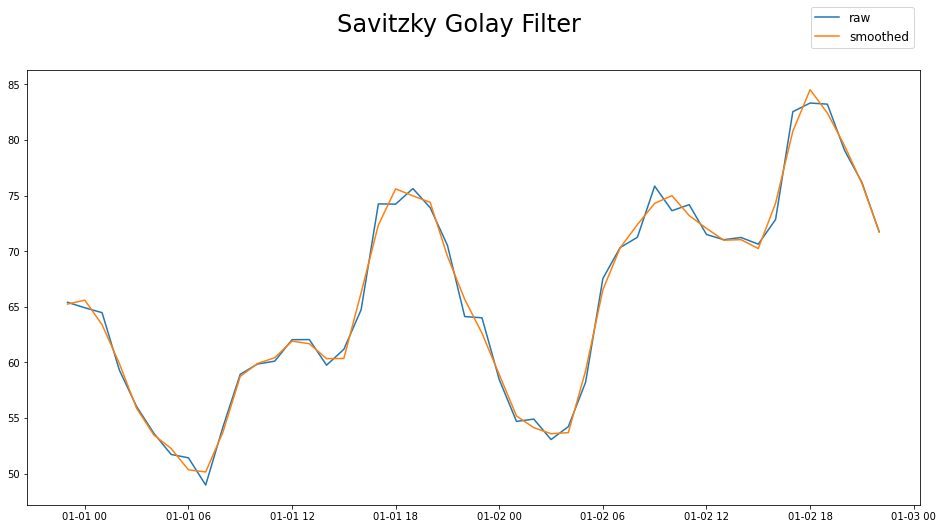

In [444]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y, label = 'raw')
ax.plot(yhat,label = 'smoothed')
fig.legend(bbox_to_anchor=(0.9,1),fontsize=12)
fig.suptitle('Savitzky Golay Filter',fontsize = 24)

Text(0.5, 0.98, 'Effect of the Savitzky Golay Filter on differencing')

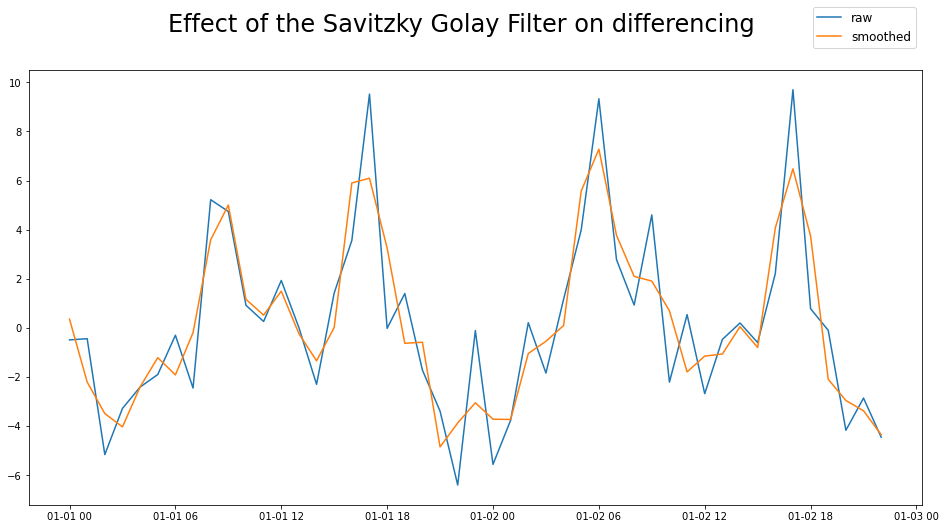

In [447]:
yhat_diff = yhat.diff().dropna()

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y.diff().dropna(), label = 'raw')
ax.plot(yhat_diff,label = 'smoothed')
fig.legend(bbox_to_anchor=(0.9,1),fontsize=12)
fig.suptitle('Effect of the Savitzky Golay Filter on differencing',fontsize = 24)

## General Feature Extension


For general features I decided to sum up all the generation methods into the feature "generation".\
Furthermore, I introduced the feature "energy_difference", which basically is an indicator for supply and demand. A positive energy difference is a energy surplus (more generation than consumption) and a negative energy difference is a energy difficit (more consumption than generation).\
From this we can also calculate "energy_stored" with the cummulated sum of the energy difference.

In [387]:
combined_df["generation"] = combined_df[generation_parameters].sum(axis=1)
combined_df["energy_difference"] = (combined_df["generation"] - combined_df["total load actual"])
combined_df["energy_stored"] = combined_df['energy_difference'].cumsum(axis=0)

## Time Feature Extension


In [388]:
# month, day, holiday
combined_df["month"] = combined_df.index.month
combined_df["day"] = combined_df.index.day
combined_df["weekend"] = np.where(df.index.weekday <= 4, 0, 1)
combined_df['hour'] = combined_df.index.hour
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,6378.0,25385.0,65.41,28251.0,2866.0,2866.0,1,1,0,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,5890.0,24382.0,64.92,27818.0,3436.0,6302.0,1,1,0,1
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,5461.0,22734.0,64.48,26796.0,4062.0,10364.0,1,1,0,2
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,5238.0,21286.0,59.32,25223.0,3937.0,14301.0,1,1,0,3
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,4935.0,20264.0,56.04,24620.0,4356.0,18657.0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,3113.0,30653.0,77.02,26415.0,-4238.0,-2062312.5,12,31,0,19
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,3288.0,29735.0,76.16,25213.0,-4522.0,-2066834.5,12,31,0,20
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,3503.0,28071.0,74.30,23987.0,-4084.0,-2070918.5,12,31,0,21
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,3586.0,25801.0,69.89,22748.0,-3053.0,-2073971.5,12,31,0,22


## Correlation Matrix


In [389]:
# Rescaling the data
featuresToScale = combined_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df = combined_df.copy(deep=True)
scaled_df.loc[:, featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])
scaled_df.sort_index(inplace=True)
scaled_df.describe()

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
count,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,...,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04,3.506400e+04
mean,3.015308e-16,6.111673e-16,2.982885e-16,5.187627e-17,-1.134793e-16,2.658659e-16,-1.167216e-16,-2.010205e-16,8.754120e-17,-3.177421e-16,...,-7.781440e-17,-2.289851e-16,2.010205e-16,-1.617080e-16,4.052833e-18,-2.593813e-17,-3.890720e-17,9.645743e-17,4.863400e-18,2.685002e-18
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,...,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-3.034543e+00,-3.935452e+00,-2.901411e+00,-1.161697e+00,-1.335441e+00,-4.493891e+00,-1.263615e+00,-2.554055e+00,-2.169529e+00,-5.680638e+00,...,-1.700610e+00,-2.329072e+00,-3.418363e+00,-5.193211e+00,-1.146634e+01,-2.211931e+00,-1.601685e+00,-1.673784e+00,-6.330616e-01,-1.661325e+00
25%,-7.787656e-01,-3.333518e-01,-7.162298e-01,-7.242735e-01,-9.201962e-01,-5.920829e-01,-1.263615e+00,-6.798612e-01,-8.815320e-01,-6.729431e-01,...,-7.879099e-01,-8.504114e-01,-6.009993e-01,-7.622765e-01,-7.005958e-01,-7.058216e-01,-7.317916e-01,-8.783552e-01,-6.330616e-01,-8.306624e-01
50%,-8.210053e-02,8.549706e-02,9.686091e-02,-2.868501e-01,-2.558045e-01,-1.937001e-01,1.717517e-01,-2.967098e-01,1.113522e-01,3.156149e-02,...,-1.915272e-01,4.452123e-02,9.573234e-03,-4.373375e-02,-1.482682e-01,2.235541e-01,1.381020e-01,3.070583e-02,-6.330616e-01,0.000000e+00
75%,7.417336e-01,4.205762e-01,8.591335e-01,5.879966e-01,9.899300e-01,5.796313e-01,8.711052e-01,3.662534e-01,8.065750e-01,6.027814e-01,...,6.019901e-01,7.640186e-01,7.129021e-01,7.003689e-01,5.128981e-01,8.823390e-01,1.007996e+00,8.261342e-01,1.579625e+00,8.306624e-01
max,2.815142e+00,5.949381e+00,1.773861e+00,4.962230e+00,1.654322e+00,2.442657e+00,1.553539e+00,6.546188e+00,2.091004e+00,2.868620e+00,...,3.725181e+00,2.691730e+00,4.147879e+00,3.265672e+00,4.487255e+00,1.348864e+00,1.587925e+00,1.735195e+00,1.579625e+00,1.661325e+00


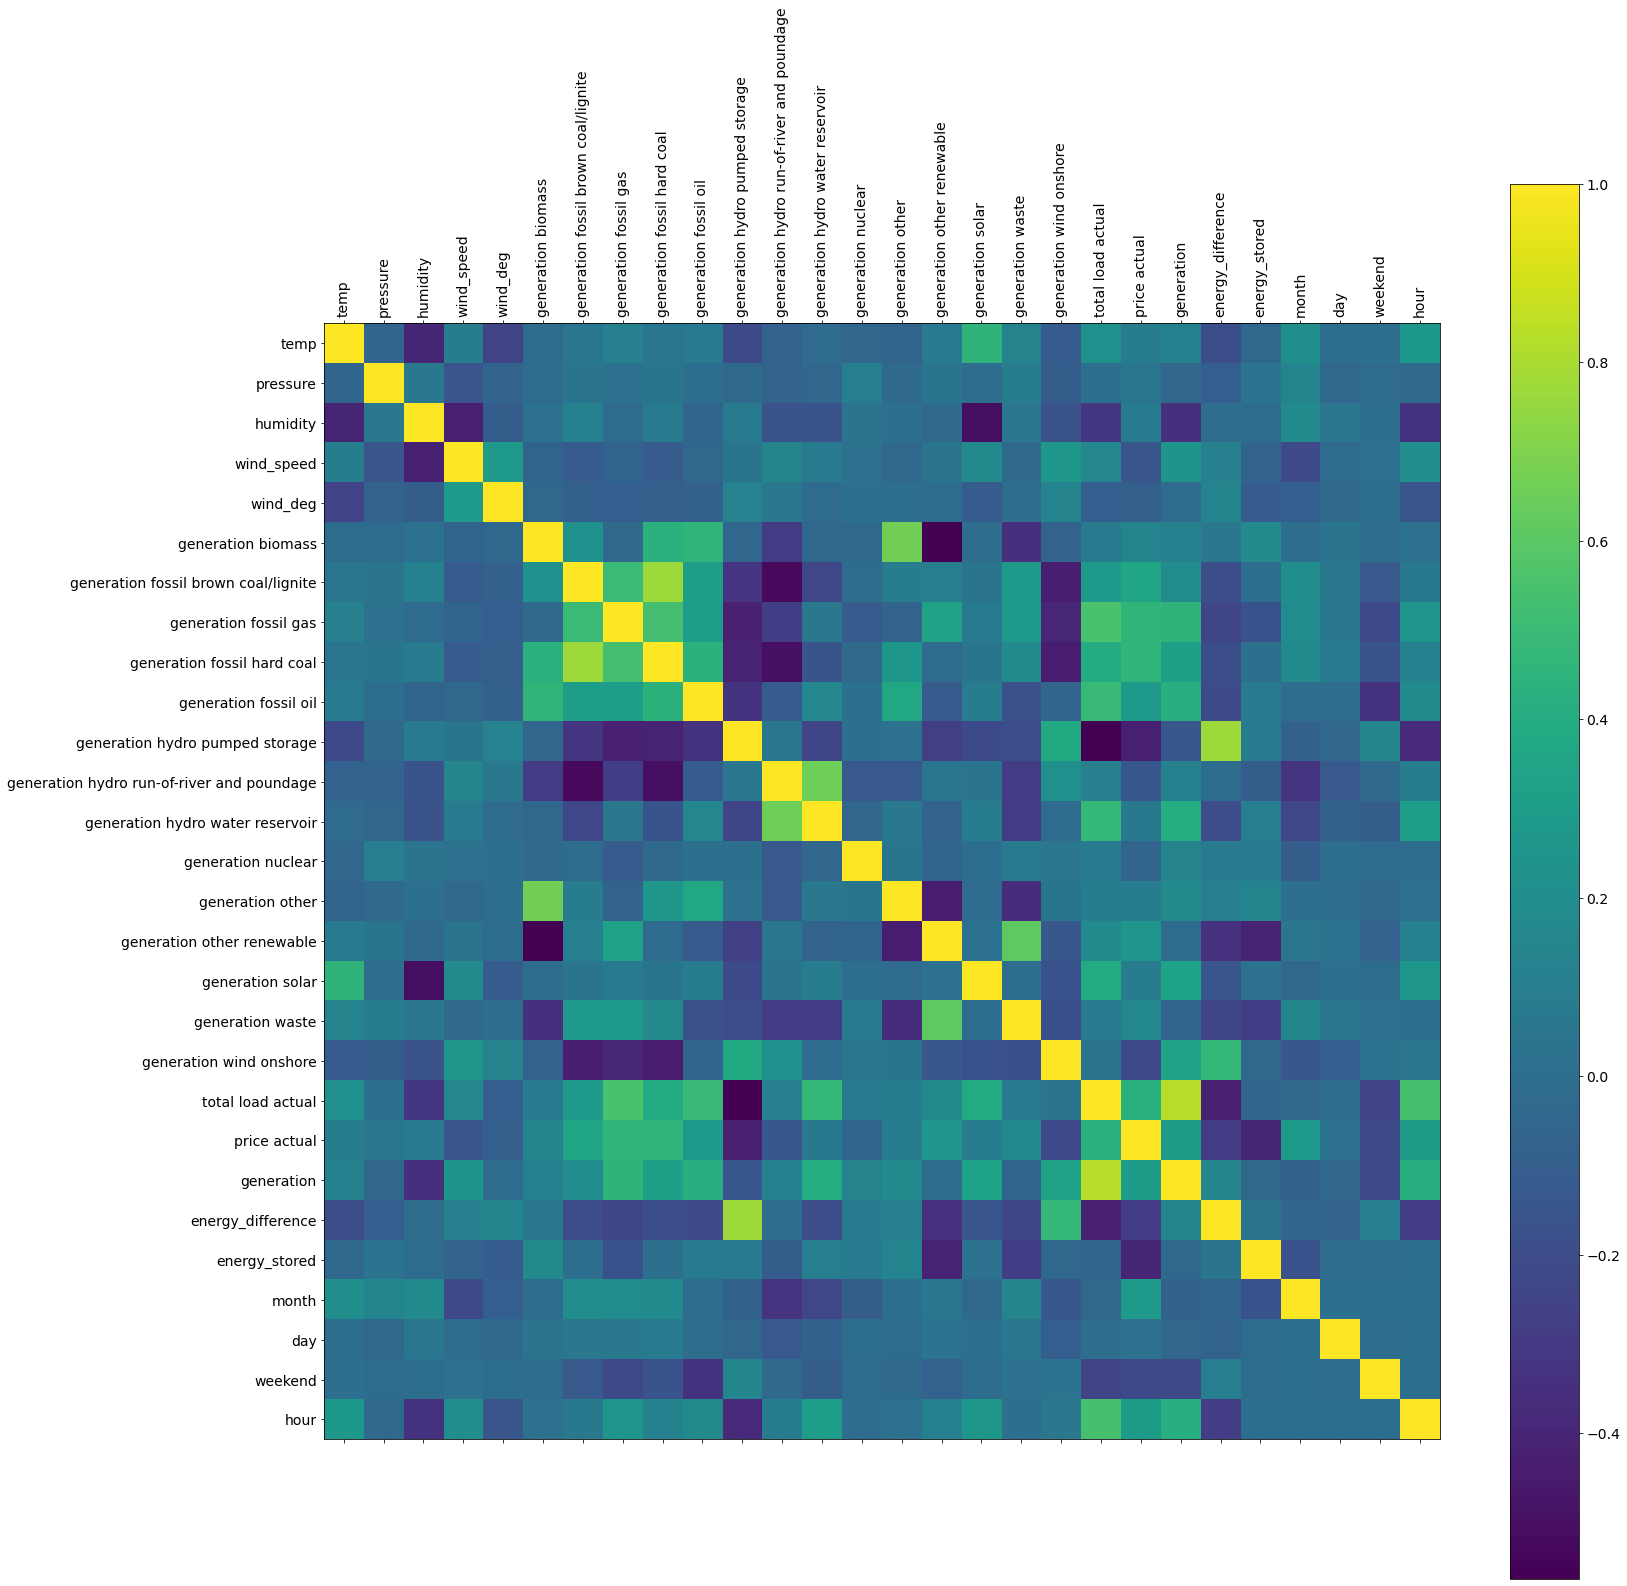

In [390]:
correlationMatrix = pd.DataFrame(scaled_df).corr()
f = plt.figure(figsize=(25, 25))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(scaled_df.shape[1]), scaled_df.columns, fontsize=14, rotation=90)
plt.yticks(range(scaled_df.shape[1]), scaled_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [391]:
# Extract high correlation pairs with upper and lower treshhold
correlations = extract_correlations(correlationMatrix, 0.5, -0.4)
for item in correlations:
    print(item)

('generation hydro pumped storage', 'total load actual', -0.5629342077948891)
('generation biomass', 'generation other renewable', -0.5605666986824334)
('generation fossil brown coal/lignite', 'generation hydro run-of-river and poundage', -0.5247213973083811)
('humidity', 'generation solar', -0.5047695097546638)
('generation fossil hard coal', 'generation hydro run-of-river and poundage', -0.4975783169794325)
('generation other', 'generation other renewable', -0.44345430163624594)
('generation fossil hard coal', 'generation wind onshore', -0.4417562740188647)
('generation fossil brown coal/lignite', 'generation wind onshore', -0.434172302338624)
('total load actual', 'energy_difference', -0.4265643564076236)
('humidity', 'wind_speed', -0.4263445615968573)
('generation hydro pumped storage', 'price actual', -0.42619560242913923)
('generation fossil gas', 'generation hydro pumped storage', -0.4207520079278396)
('generation other renewable', 'energy_stored', -0.4106425966947026)
('generat

## PCA Analysis


In [392]:
n_components = None
whiten = False
svd_solver = "auto"
random_state = 2020

pca = PCA(
    n_components=n_components,
    whiten=whiten,
    svd_solver=svd_solver,
    random_state=random_state,
)

x_pca = pca.fit(scaled_df)

Text(0, 0.5, 'cumulative explained variance')

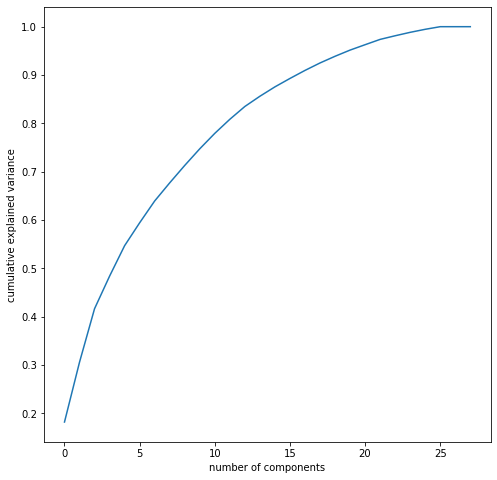

In [393]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

In [394]:
# Reduce the dimensions so that 95% of the variance is kept
pca = PCA(n_components=0.95)
# this will fit and reduce dimensions
X_pca = pca.fit_transform(scaled_df)
print('Total number of features: ', len(combined_df.columns))
print('Number of features to keep 95% of the variance in the dataset: ',pca.n_components_)

Total number of features:  28
Number of features to keep 95% of the variance in the dataset:  20


In [395]:
pd.DataFrame(pca.components_, columns=scaled_df.columns)

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
0,-0.141441,-0.026427,0.068460,0.015388,0.088759,-0.091963,-0.279046,-0.327695,-0.318665,-0.248630,...,0.180542,-0.351356,-0.294039,-0.234544,0.242414,0.061291,-0.090549,-0.031283,0.129448,-0.214647
1,0.083862,-0.093936,-0.321116,0.257949,0.049804,0.007716,-0.233792,-0.080465,-0.175546,0.098815,...,0.259561,0.263609,-0.071057,0.322827,0.056249,0.061952,-0.223093,-0.075767,-0.040521,0.234107
2,0.109872,0.013059,-0.092814,0.083623,0.014705,-0.467213,-0.125344,0.060610,-0.218320,-0.258578,...,-0.028849,0.030780,0.021574,-0.077189,-0.179710,-0.231636,0.005101,-0.005549,0.037271,0.080972
3,-0.174731,0.082319,0.268993,-0.321242,-0.167278,0.001096,-0.144864,-0.072081,-0.105542,0.066387,...,-0.262329,0.001052,0.016389,-0.233928,-0.381166,0.144290,-0.104527,-0.019598,-0.084713,-0.017321
4,0.466482,0.022735,-0.272530,-0.009261,-0.260145,0.083282,-0.030253,-0.170421,-0.050618,-0.102614,...,-0.243476,-0.109270,-0.213231,-0.233121,-0.184332,0.278907,0.059693,0.057459,0.242897,0.100960
5,0.251857,0.028649,0.056960,-0.231438,-0.272650,0.057654,-0.176896,-0.012703,-0.117717,-0.012679,...,0.179038,-0.047583,0.313512,0.035756,0.142308,-0.368412,0.500517,-0.150935,0.059105,0.082923
6,-0.023178,-0.465268,-0.114616,0.270091,0.380120,0.171169,0.031925,0.000847,0.075324,-0.007358,...,-0.161996,-0.128884,0.071512,-0.214746,-0.119776,-0.251965,-0.087825,0.160659,0.100196,-0.043640
7,-0.069511,0.387522,-0.029928,0.138403,0.333066,0.191845,-0.133663,-0.271466,-0.056447,-0.023636,...,0.046791,0.014672,0.176767,-0.135130,-0.245109,-0.282809,0.082056,-0.131483,0.311647,0.126380
8,-0.073975,-0.270196,0.182739,-0.054487,-0.277580,0.036282,-0.061750,-0.017777,-0.026650,-0.122302,...,0.158790,0.073069,0.070905,0.082665,0.004536,-0.048333,-0.059611,0.662562,0.394434,0.277924
9,-0.172765,-0.042723,0.066738,0.021152,-0.044588,-0.030687,0.192421,0.169805,0.150620,-0.225243,...,-0.072559,0.043218,-0.065085,0.104041,0.092102,0.165148,-0.041268,-0.509776,0.615313,0.212159


In [396]:
n_pcs = pca.n_components_

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = scaled_df.columns

# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print("Most important components:")
for item in most_important_names:
    print(item)

print("")

print("Least important components:")
for item in scaled_df.columns:
    if item not in most_important_names:
        print(item)

Most important components:
total load actual
generation hydro water reservoir
generation biomass
generation hydro water reservoir
temp
month
generation nuclear
pressure
day
weekend
pressure
generation solar
month
wind_speed
wind_speed
generation other
generation other
generation other
generation fossil oil
humidity

Least important components:
wind_deg
generation fossil brown coal/lignite
generation fossil gas
generation fossil hard coal
generation hydro pumped storage
generation hydro run-of-river and poundage
generation other renewable
generation waste
generation wind onshore
price actual
generation
energy_difference
energy_stored
hour


## Decomposition


In [397]:
feature = 'price actual'

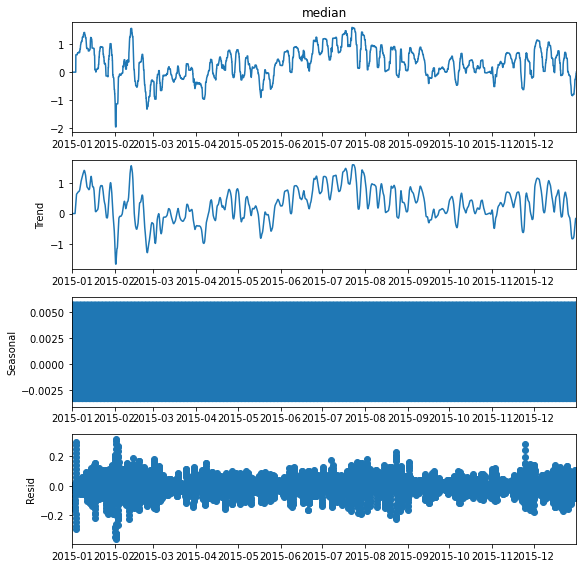

In [398]:
fig = display_seasonal_decomposition(
    scaled_df["2015-01-01 00:00:00":"2015-12-31 23:00:00"],
    feature,
    72,
    "median",
)

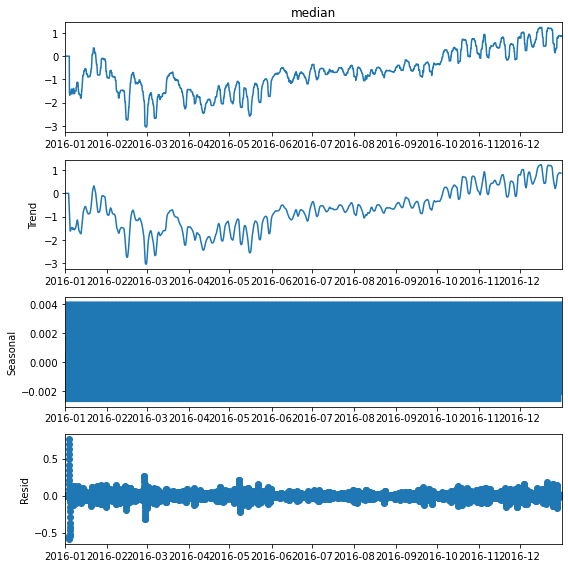

In [399]:
fig = display_seasonal_decomposition(
    scaled_df["2016-01-01 00:00:00":"2016-12-31 23:00:00"],
    feature,
    72,
    "median",
)

## Autocorrelation and Partial Autocorrelation


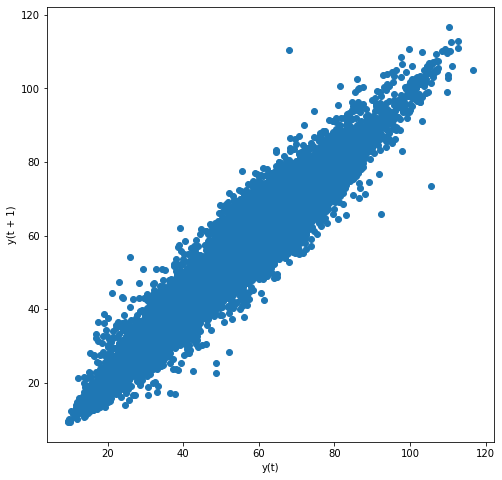

In [400]:
fig = lag_plot(combined_df[feature])

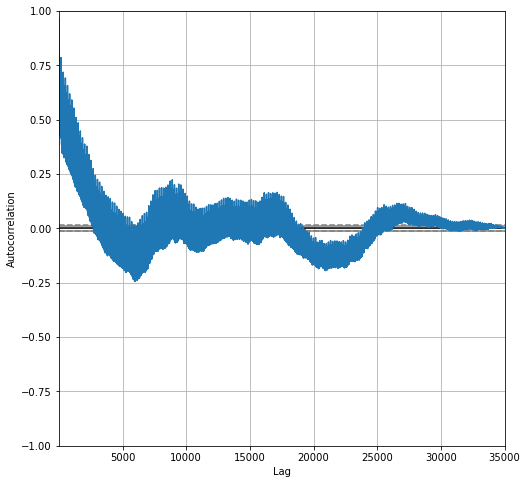

In [401]:
# Checking autocorrelations:
fig = autocorrelation_plot(combined_df[feature])

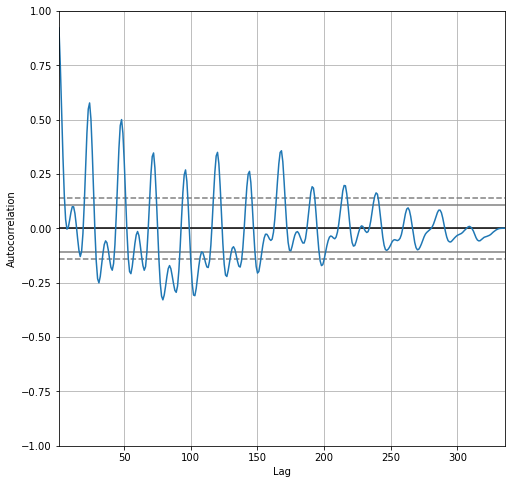

In [402]:
# Checking autocorrelations:
subset = combined_df[feature]["2015-01-01":"2015-01-14"]
fig = autocorrelation_plot(subset)

<Figure size 576x576 with 0 Axes>

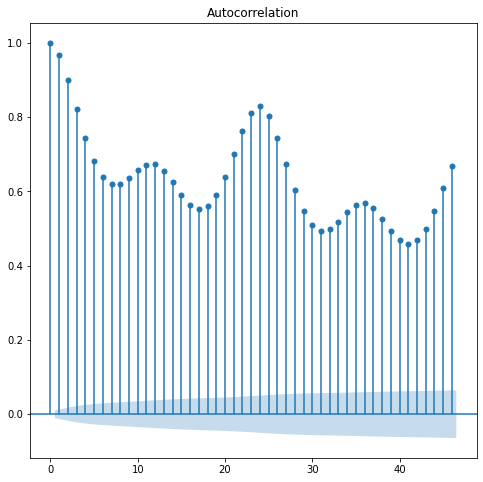

In [403]:
plt.figure()
fig = plot_acf(combined_df[feature])

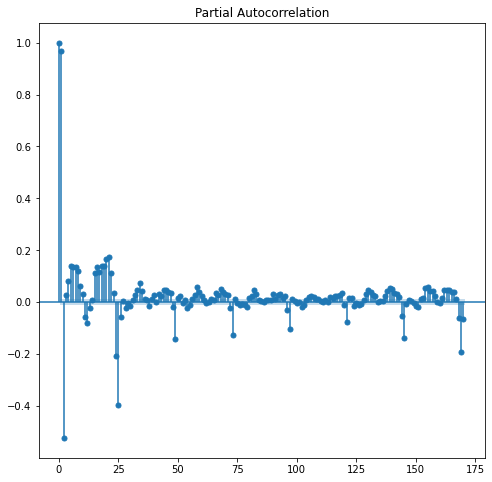

In [404]:
fig = plot_pacf(combined_df[feature], lags=170)